# Balanced Approach Rule and Balanced-approach (Shortfalls) Rule

*By Nathan Ramos, CFA*

The Balanced Approach Rule and its variant, the Balanced-approach (Shortfalls) Rule, are monetary policy guidelines that adjust nominal interest rates based on deviations in inflation and unemployment. These rules, differing from the traditional Taylor Rule, significantly emphasize unemployment metrics, with the Balanced-approach (Shortfalls) Rule specifically targeting employment shortfalls to provide stimulus during severe economic downturns without overreacting to positive conditions. 

In this notebook, using the `pyeconomics` package, we will compute and analyze these interest rates using real-time and historical data from the FRED database to see how these guidelines could influence monetary policy decisions.

## Importing Necessary Libraries

Before we begin the computations, we need to import the necessary libraries that will enable us to fetch data, perform calculations, and visualize results. This includes libraries for data manipulation, API access, and plotting.

In [1]:
# Import standard libraries
import sys
import os

# Configure system path
sys.path.insert(0, os.path.abspath('../../'))

# Import third-party libraries
import pandas as pd
import matplotlib.pyplot as plt

# Import pyeconomics modules
from pyeconomics import balanced_approach_rule
from pyeconomics import historical_balanced_approach_rule
from pyeconomics import fetch_historical_fed_funds_rate
from pyeconomics import fred_client
from pyeconomics import verbose_taylor_rule

# Set up display for plots
%matplotlib inline

## Configuring API Access to FRED

To leverage the real-time data fetching capabilities of the `pyeconomics` package for Taylor Rule calculations, configure your FRED API access by [securely setting up your API key](../api_configuration/fred_api_configuration.ipynb). A detailed step-by-step guide on obtaining and securely storing your FRED API key with the `keyring` library is available in our dedicated notebook, ensuring compliance with FRED's security policies and preventing unauthorized access.

## FRED Series IDs for Economic Data

In this section, we define the series identifiers (IDs) used to fetch economic data from the FRED (Federal Reserve Economic Data) database, crucial for the calculations of the Balanced Approach Rule and its variant, the Balanced-approach (Shortfalls) Rule. These identifiers allow users to select specific data series that align with their analytical needs or data availability. The IDs provided below correspond to key economic indicators relevant to both rules:

- **Inflation Series ID (`inflation_series_id`):** Points to the series used to measure the inflation rate, typically set to track the PCE Trimmed Mean Inflation Rate for a consistent measure of inflation, free from the most extreme price movements.
- **Unemployment Rate Series ID (`unemployment_rate_series_id`):** Specifies the series for measuring the general unemployment rate, essential for assessing overall employment health.
- **Natural Unemployment Series ID (`natural_unemployment_series_id`):** Indicates the series for the natural rate of unemployment, reflecting the long-term unemployment level unaffected by cyclical fluctuations and economic policies.
- **Real Interest Rate Series ID (`real_interest_rate_series_id`):** Represents the series for the long-term real interest rate, critical for evaluating the real cost of borrowing and the economic baseline for interest rate adjustments.

Setting accurate series IDs ensures that the calculations for both the Balanced Approach Rule and the Balanced-approach (Shortfalls) Rule are based on relevant and current economic data.


In [2]:
# FRED Series IDs for economic data
inflation_series_id = 'PCETRIM12M159SFRBDAL'
unemployment_rate_series_id = 'UNRATE'
natural_unemployment_series_id = 'NROU'
real_interest_rate_series_id = 'DFII10'

# Print the series names and their IDs
print(f"Inflation Series ID:               {fred_client.get_series_name(inflation_series_id)}")
print(f"Unemployment Rate Series ID:       {fred_client.get_series_name(unemployment_rate_series_id)}")
print(f"Natural Unemployment Series ID:    {fred_client.get_series_name(natural_unemployment_series_id)}")
print(f"Real Interest Rate Series ID:      {fred_client.get_series_name(real_interest_rate_series_id)}")

Inflation Series ID:               Trimmed Mean PCE Inflation Rate
Unemployment Rate Series ID:       Unemployment Rate
Natural Unemployment Series ID:    Noncyclical Rate of Unemployment
Real Interest Rate Series ID:      Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis, Inflation-Indexed


## Model Assumptions and Parameters

This section outlines the assumptions and parameters used in the Balanced Approach Rule calculation. These values can be adjusted to simulate different economic conditions and policy responses:

- **Inflation Target (`inflation_target`):** The target inflation rate, typically set by the central bank, which guides their monetary policy objectives.
- **Alpha (α) (`alpha`):** Represents the responsiveness of the policy interest rate to the inflation gap, i.e., the difference between actual inflation and the target inflation.
- **Beta (β) (`beta`):** Indicates how sensitive the policy rate is to changes in the output gap, which is the deviation of actual GDP from its potential level.
- **Okun's Factor (`okun_factor`):** Adjusts the response to changes in the unemployment gap, based on Okun's law, which describes the relationship between changes in unemployment and GDP.
- **Rho (ρ) (`rho`):** This parameter adds inertia to the policy rate, reflecting the tendency of central banks to avoid large swings in interest rate changes.
- **Effective Lower Bound (ELB) (`elb`):** Sets a minimum value for the policy rate to prevent the recommendation of negative or impractically low interest rates.
- **Apply ELB (`apply_elb`):** A boolean control that determines whether the effective lower bound should be enforced in the Taylor Rule calculation.
- **Verbose (`verbose`):** A boolean setting that, when enabled, provides detailed output about the internal calculations and economic indicators used during the computation.

By tweaking these parameters, researchers and policymakers can explore how various theoretical adjustments might affect the recommended policy rate under the Taylor Rule.

In [3]:
# Model Assumptions
inflation_target = 2.0
alpha = 0.5
beta = 2.0
rho = 0.70
elb = 0.125
apply_elb = True
verbose = True

## Current Balanced Approach Rule Calculation Using the FRED API

This section demonstrates the computation of the current recommended interest rate according to the Balanced Approach Rule, utilizing real-time economic indicators fetched directly from the FRED (Federal Reserve Economic Data) API. [Ensure that your API credentials are correctly configured to fetch this data.](../api_configuration/fred_api_configuration.ipynb)

### Balanced Approach Rule Formula

The Balanced Approach Rule adjusts the policy interest rate based on deviations in inflation and unemployment from their target or natural rates, incorporating a stronger emphasis on unemployment deviations. The formula is expressed as:

$$
i_t = r_t + \pi_t + 0.5(\pi_t - \pi^*) + 2(u^* - u_t)
$$

Where:
- $i_t$: Recommended policy interest rate
- $r_t$: Real neutral interest rate, typically reflecting long-term economic conditions
- $\pi_t$: Current inflation rate
- $\pi^*$: Target inflation rate, set by the central bank
- $u^*$: Natural rate of unemployment
- $u_t$: Current unemployment rate

This formula underscores the central bank’s dual mandate to control inflation and promote full employment. Here, the coefficient 0.5 for the inflation gap indicates a moderate response to inflation deviations, ensuring stability without overreacting to short-term inflation fluctuations. The coefficient 2.0 for the unemployment gap signifies a stronger response to unemployment changes, reflecting a heightened priority on minimizing unemployment relative to the inflation target. This differential weighting emphasizes the balanced approach towards maintaining economic stability while addressing significant concerns about labor market conditions.

In [4]:
# Current Balanced Approach Rule calculation
current_bar_rate_fred = balanced_approach_rule(
    inflation_series_id,
    unemployment_rate_series_id,
    natural_unemployment_series_id,
    real_interest_rate_series_id,
    inflation_target=inflation_target,
    alpha=alpha,
    beta=beta,
    rho=rho,
    elb=elb,
    apply_elb=apply_elb,
    verbose=verbose
)


==== Economic Indicators =============================================
Current Inflation:                               3.04%
Target Inflation:                                2.00%
Current Unemployment Rate:                       3.90%
Natural Unemployment Rate:                       4.41%
Long-Term Real Interest Rate:                    2.10%
Current Fed Rate:                                5.50%
As of Date:                                      May 21, 2024

==== Gaps ============================================================
Inflation Gap:                                   1.04%
Unemployment Gap:                                0.51%

==== Balanced Approach Rule ==========================================
  Long-Term Real Interest Rate:                  2.10%
  Current Inflation:                             + 3.04%
  Alpha * Inflation Gap:                         + 0.50 * 1.04%
  Beta * Unemployment Gap:                       + 2.00 * 0.51%
------------------------------------------

## Current Balanced-approach (Shortfalls) Rule Calculation Using the FRED API

This section demonstrates the computation of the current recommended interest rate according to the Balanced-approach (Shortfalls) Rule, utilizing real-time economic indicators fetched directly from the FRED (Federal Reserve Economic Data) API. [Ensure that your API credentials are correctly configured to fetch this data.](../api_configuration/fred_api_configuration.ipynb)

### Balanced-approach (Shortfalls) Rule Formula

The Balanced-approach (Shortfalls) Rule adjusts the policy interest rate specifically focusing on shortfalls in employment rather than general deviations. This rule places significant emphasis on instances where unemployment exceeds its natural rate. The formula is expressed as:

$$
i_t = r_t + \pi_t + 0.5(\pi_t - \pi^*) + 2\min{(u^* - u_t, 0)}
$$

Where:
- $i_t$: Recommended policy interest rate
- $r_t$: Real neutral interest rate, typically reflecting long-term economic conditions
- $\pi_t$: Current inflation rate
- $\pi^*$: Target inflation rate, set by the central bank
- $u^*$: Natural rate of unemployment
- $u_t$: Current unemployment rate

This formula targets the more acute economic issues by responding only to unemployment rates that exceed the natural level, thereby focusing policy efforts on serious economic downturns without reacting to fluctuations that do not indicate significant employment shortfalls. The coefficient 0.5 for the inflation gap moderates the response to inflation, while the application of a 2.0 multiplier to only negative unemployment deviations (shortfalls) ensures that the policy is aggressive only when necessary to combat rising unemployment.


In [5]:
use_shortfalls_rule = True # Set to True to use Balanced Approach (Shortfalls) Rule

In [6]:
# Current Balanced Approach (Shortfalls) Rule calculation
current_basr_rate_fred = balanced_approach_rule(
    inflation_series_id,
    unemployment_rate_series_id,
    natural_unemployment_series_id,
    real_interest_rate_series_id,
    inflation_target=inflation_target,
    alpha=alpha,
    beta=beta,
    rho=rho,
    elb=elb,
    apply_elb=apply_elb,
    use_shortfalls_rule=True,
    verbose=verbose
)


==== Economic Indicators ==============================================
Current Inflation:                               3.04%
Target Inflation:                                2.00%
Current Unemployment Rate:                       3.90%
Natural Unemployment Rate:                       4.41%
Long-Term Real Interest Rate:                    2.10%
Current Fed Rate:                                5.50%
As of Date:                                      May 21, 2024

==== Gaps =============================================================
Inflation Gap:                                   1.04%
Unemployment Gap:                                0.00%

==== Balanced Approach Shortfalls Rule (BASR) =========================
  Long-Term Real Interest Rate:                  2.10%
  Current Inflation:                             + 3.04%
  Alpha * Inflation Gap:                         + 0.50 * 1.04%
  Beta * Unemployment Gap:                       + 2.00 * 0.00%
---------------------------------------

## Setting Preset Economic Indicators for Stagflation Simulation

Users can manually input preset values for key economic indicators to compute the interest rate according to the Balanced Approach Rule (BAR) or the Balanced Approach Shortfalls Rule (BASR). These methods allow for simulations under specific economic scenarios such as stagflation, which is characterized by high inflation and unemployment alongside sluggish economic growth:

- **Current Inflation Rate:** Set at 6.0% to simulate high inflation, indicative of rising prices during a period of economic challenge.
- **Current Unemployment Rate:** Preset at 6.0%, adjusted to reflect high unemployment that matches the inflation rate, showing substantial economic underperformance and labor market distress.
- **Natural Unemployment Rate:** Set at 4.5%, representing a baseline where the labor market is more stable without cyclical pressures.
- **Long-Term Real Interest Rate:** Established at 2.0%, assuming a realistic but somewhat elevated rate of return due to heightened economic uncertainty.
- **Federal Funds Rate:** Preset at 8.0% to demonstrate the central bank's aggressive monetary policy stance to combat inflation while trying to stabilize the economy amidst challenging conditions.

These settings are used to explore the impact of stagflation on the recommended policy interest rate under both the BAR and BASR. The BASR is particularly relevant in scenarios where actual unemployment rates exceed the natural rate, indicating more severe economic shortfalls and challenges.

In [7]:
# Preset values for economic indicators in a stagflation scenario
current_inflation_rate = 6.0
current_unemployment_rate = 6.0
natural_unemployment_rate = 4.5
long_term_real_interest_rate = 2.0
current_fed_rate = 8.0

In [8]:
# Current Balanced Approach Rule calculation
current_bar_rate_preset = balanced_approach_rule(
    current_inflation_rate=current_inflation_rate,
    current_unemployment_rate=current_unemployment_rate,
    natural_unemployment_rate=natural_unemployment_rate,
    long_term_real_interest_rate=long_term_real_interest_rate,
    current_fed_rate=current_fed_rate,
    inflation_target=inflation_target,
    alpha=alpha,
    beta=beta,
    rho=rho,
    elb=elb,
    apply_elb=apply_elb,
    verbose=verbose
)


==== Economic Indicators =============================================
Current Inflation:                               6.00%
Target Inflation:                                2.00%
Current Unemployment Rate:                       6.00%
Natural Unemployment Rate:                       4.50%
Long-Term Real Interest Rate:                    2.00%
Current Fed Rate:                                8.00%
As of Date:                                      May 21, 2024

==== Gaps ============================================================
Inflation Gap:                                   4.00%
Unemployment Gap:                                -1.50%

==== Balanced Approach Rule ==========================================
  Long-Term Real Interest Rate:                  2.00%
  Current Inflation:                             + 6.00%
  Alpha * Inflation Gap:                         + 0.50 * 4.00%
  Beta * Unemployment Gap:                       + 2.00 * -1.50%
----------------------------------------

In [9]:
# Current Balanced Approach (Shortfalls) Rule calculation
current_basr_rate_preset = balanced_approach_rule(
    current_inflation_rate=current_inflation_rate,
    current_unemployment_rate=current_unemployment_rate,
    natural_unemployment_rate=natural_unemployment_rate,
    long_term_real_interest_rate=long_term_real_interest_rate,
    current_fed_rate=current_fed_rate,
    inflation_target=inflation_target,
    alpha=alpha,
    beta=beta,
    rho=rho,
    elb=elb,
    apply_elb=apply_elb,
    use_shortfalls_rule=True,
    verbose=verbose
)


==== Economic Indicators ==============================================
Current Inflation:                               6.00%
Target Inflation:                                2.00%
Current Unemployment Rate:                       6.00%
Natural Unemployment Rate:                       4.50%
Long-Term Real Interest Rate:                    2.00%
Current Fed Rate:                                8.00%
As of Date:                                      May 21, 2024

==== Gaps =============================================================
Inflation Gap:                                   4.00%
Unemployment Gap:                                -1.50%

==== Balanced Approach Shortfalls Rule (BASR) =========================
  Long-Term Real Interest Rate:                  2.00%
  Current Inflation:                             + 6.00%
  Alpha * Inflation Gap:                         + 0.50 * 4.00%
  Beta * Unemployment Gap:                       + 2.00 * -1.50%
-------------------------------------

### Policy Prescription Summary for Stagflation Scenario

In the stagflation scenario characterized by a high inflation rate of 6.00% and an unemployment rate of 6.00%, both the Balanced Approach Rule (BAR) and the Balanced Approach Shortfalls Rule (BASR) suggest similar policy responses. The calculations are based on an inflation gap of 4.00% and an unemployment gap of -1.50%. Starting with a long-term real interest rate of 2.00% and adjustments for current inflation and unemployment gaps, the initial unadjusted interest rate estimates for both rules are 7.00%. This is then compared against an effective lower bound (ELB) of 0.12%, maintaining the rate at 7.00%. Further adjustments are made for policy inertia with a coefficient of 0.70 and the current Federal Funds Rate of 8.00%, leading to a final adjusted policy interest rate of 7.70% for both rules. These calculations indicate a cautious yet responsive approach to monetary policy aimed at curbing inflation while considering the high unemployment, ensuring a balanced response to the economic distress characterized by high inflation and unemployment. This aims to preserve economic stability without exacerbating unemployment issues.

## Historical Balanced Approach Rule (BAR) and Balanced Approach Shortfalls Rule (BASR) Calculations

Now, we will compute the interest rates based on historical data sourced from the FRED API using both the Balanced Approach Rule (BAR) and the Balanced Approach Shortfalls Rule (BASR). 

In [10]:
# Historical BAR calculation using FRED data
bar_historical_rates_fred = historical_balanced_approach_rule(
    inflation_series_id,
    unemployment_rate_series_id,
    natural_unemployment_series_id,
    real_interest_rate_series_id,
    inflation_target=inflation_target,
    alpha=alpha,
    beta=beta
)

In [11]:
# Historical BASR calculation using FRED data
basr_historical_rates_fred = historical_balanced_approach_rule(
    inflation_series_id,
    unemployment_rate_series_id,
    natural_unemployment_series_id,
    real_interest_rate_series_id,
    inflation_target=inflation_target,
    alpha=alpha,
    beta=beta,
    use_shortfalls_rule=True
)

In [12]:
# Adjusted Historical BAR calculation using FRED data
adj_bar_historical_rates_fred = historical_balanced_approach_rule(
    inflation_series_id,
    unemployment_rate_series_id,
    natural_unemployment_series_id,
    real_interest_rate_series_id,
    inflation_target=inflation_target,
    alpha=alpha,
    beta=beta,
    rho=rho,
    apply_elb=apply_elb
)

In [13]:
# Adjusted Historical BASR calculation using FRED data
adj_basr_historical_rates_fred = historical_balanced_approach_rule(
    inflation_series_id,
    unemployment_rate_series_id,
    natural_unemployment_series_id,
    real_interest_rate_series_id,
    inflation_target=inflation_target,
    alpha=alpha,
    beta=beta,
    use_shortfalls_rule=True,
    rho=rho,
    apply_elb=apply_elb
)

## Visualization of Historical BAR and BASR Data

Plotting the historical estimates from the Balanced Approach Rule (BAR) and Balanced Approach Shortfalls Rule (BASR) provides visual insights into how recommendations for monetary policy might have changed in response to economic indicators over time. 

In [14]:
# Combine BAR and BASR historical rates
historical_rates = pd.concat([bar_historical_rates_fred, basr_historical_rates_fred], axis=1)
historical_rates = historical_rates.loc[:, ~historical_rates.columns.duplicated()]

In [15]:
# Combine Adjusted BAR and BASR historical rates
adj_historical_rates = pd.concat([adj_bar_historical_rates_fred, adj_basr_historical_rates_fred], axis=1)
adj_historical_rates = adj_historical_rates.loc[:, ~adj_historical_rates.columns.duplicated()]

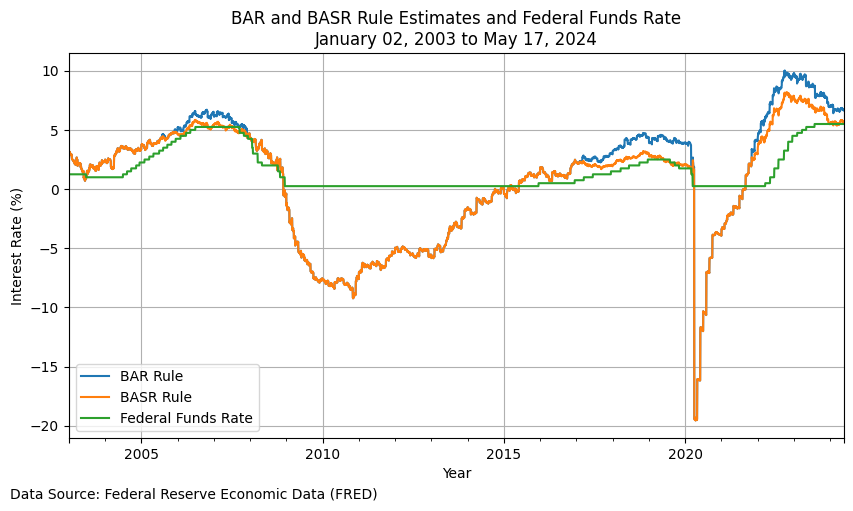

In [16]:
plot_data = historical_rates[[
    'BalancedApproachRule',
    'BalancedApproachShortfallsRule',
    'FedRate'
]].copy()

# Extracting the time range from the data
start_date = plot_data.dropna().index.min()
end_date = plot_data.dropna().index.max()
date_range = f"{start_date.strftime('%B %d, %Y')} to {end_date.strftime('%B %d, %Y')}"

# Plotting BAR and BASR Rule estimates and the Federal Funds Rate
plot_data.dropna().plot(
    figsize=(10, 5),  # Specifies the figure size
    grid=True  # Enables grid lines for better readability
)

plt.title(f'BAR and BASR Rule Estimates and Federal Funds Rate\n{date_range}')

plt.xlabel('Year')
plt.ylabel('Interest Rate (%)')
plt.legend(['BAR Rule', 'BASR Rule', 'Federal Funds Rate'])

# Adding the citation as a footnote
plt.figtext(
    x=0.25,
    y=-0.01,
    s="Data Source: Federal Reserve Economic Data (FRED)", 
    ha="center"
)

plt.show()  # Display the plot

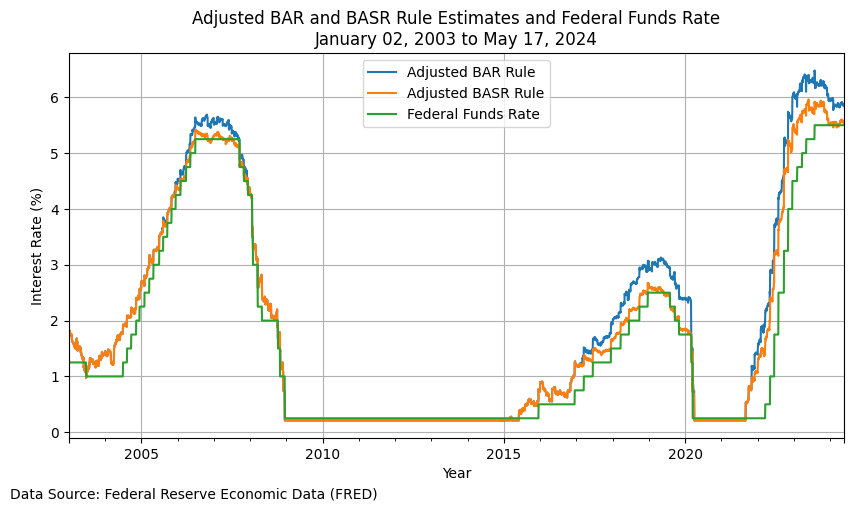

In [17]:
plot_data = adj_historical_rates[[
    'AdjustedBalancedApproachRule',
    'AdjustedBalancedApproachShortfallsRule',
    'FedRate'
]].copy()

# Extracting the time range from the data
start_date = plot_data.dropna().index.min()
end_date = plot_data.dropna().index.max()
date_range = f"{start_date.strftime('%B %d, %Y')} to {end_date.strftime('%B %d, %Y')}"

# Plotting Adjusted BAR and BASR Rule estimates and the Federal Funds Rate
plot_data.dropna().plot(
    figsize=(10, 5),  # Specifies the figure size
    grid=True  # Enables grid lines for better readability
)

plt.title(f'Adjusted BAR and BASR Rule Estimates and Federal Funds Rate\n{date_range}')

plt.xlabel('Year')
plt.ylabel('Interest Rate (%)')
plt.legend(['Adjusted BAR Rule', 'Adjusted BASR Rule', 'Federal Funds Rate'])

# Adding the citation as a footnote
plt.figtext(
    x=0.25,
    y=-0.01,
    s="Data Source: Federal Reserve Economic Data (FRED)", 
    ha="center"
)

plt.show()  # Display the plot

# Conclusion

This notebook demonstrates the use of the `pyeconomics` package to calculate and visualize the Balanced Approach Rule (BAR) and the Balanced Approach Shortfalls Rule (BASR). These tools can aid economists, policymakers, and financial analysts in understanding and predicting central bank behavior regarding interest rates under varying economic conditions. 
